# Simulasi Penataan Kontainer Kapal

Notebook ini mensimulasikan penataan kontainer berdasarkan kategori berat (berat/sedang/ringan) dan tujuan pelabuhan (Makassar, Ambon, Jayapura), dengan aturan:

- Kontainer berat ditempatkan di bawah, sedang di tengah, ringan di atas.
- Aksesibilitas bongkar: kontainer untuk pelabuhan awal harus lebih mudah diakses (lebih atas) dibanding pelabuhan akhir.
- Kapasitas contoh: 450 kontainer, dibagi ke 9 bay, masing-masing 50 slot (10 stack × 5 tier).

Visualisasi menggunakan color coding:
- Hijau: ringan
- Kuning: sedang
- Merah: berat

Silakan jalankan sel-sel di bawah berurutan.


In [52]:
# Setup: impor dan utilitas
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# Konstanta kategori berat
WEIGHT_CATEGORIES = ["light", "medium", "heavy"]
WEIGHT_TO_COLOR = {"light": "#2ecc71", "medium": "#f1c40f", "heavy": "#e74c3c"}
WEIGHT_PRIORITY = {"heavy": 0, "medium": 1, "light": 2}  # untuk stacking bottom-up

# Struktur kontainer
@dataclass
class Container:
    id: int
    dest: str
    weight_cat: str
    weight_ton: float  # berat numerik aktual

# Struktur posisi: bay, stack (kolom), tier (baris/tinggi)
@dataclass
class Position:
    bay: int
    stack: int
    tier: int



In [53]:
# Parameter simulasi (dapat diubah)
TOTAL_CONTAINERS = 450
BAYS = 9
STACKS_PER_BAY = 10   # kolom per bay
TIERS_PER_STACK = 5   # tinggi per stack
assert BAYS * STACKS_PER_BAY * TIERS_PER_STACK == 450

# Urutan pelabuhan pada rute (awal -> akhir)
PORTS = ["Makassar", "Ambon", "Jayapura"]

# Alokasi jumlah kontainer per tujuan
ALLOCATION_PER_PORT = {
    "Makassar": 200,
    "Ambon": 150,
    "Jayapura": TOTAL_CONTAINERS - 200 - 150,
}

# Proporsi kategori berat per tujuan (akan dinormalisasi jika tidak pas 1.0)
WEIGHT_MIX = {
    "Makassar": {"light": 0.6, "medium": 0.3, "heavy": 0.1},
    "Ambon":    {"light": 0.3, "medium": 0.5, "heavy": 0.2},
    "Jayapura": {"light": 0.25, "medium": 0.45, "heavy": 0.30},
}

# Pembagian bay per tujuan (dapat diubah)
PORT_TO_BAYS = {
    "Makassar": [3, 4, 5, 6],
    "Ambon": [1, 2, 7],
    "Jayapura": [0, 8],
}

# Rentang berat (ton) per kategori
WEIGHT_RANGES = {
    "light": (5.0, 12.9),
    "medium": (13.0, 19.9),
    "heavy": (20.0, 25.0),
}



In [54]:
def normalize_mix(mix: Dict[str, float]) -> Dict[str, float]:
    total = sum(mix.values())
    if total == 0:
        # fallback rata
        n = len(mix)
        return {k: 1.0 / n for k in mix}
    return {k: v / total for k, v in mix.items()}


def generate_containers(
    total: int,
    allocation_per_port: Dict[str, int],
    weight_mix: Dict[str, Dict[str, float]],
) -> List[Container]:
    containers: List[Container] = []
    container_id = 1
    for port, count in allocation_per_port.items():
        mix = normalize_mix(weight_mix.get(port, {c: 1/3 for c in WEIGHT_CATEGORIES}))
        # jumlah per kategori via multinomial
        probs = [mix.get("light", 0), mix.get("medium", 0), mix.get("heavy", 0)]
        cat_counts = np.random.multinomial(count, probs)
        cats = ["light", "medium", "heavy"]
        for cat, c in zip(cats, cat_counts):
            for _ in range(c):
                wmin, wmax = WEIGHT_RANGES[cat]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=port, weight_cat=cat, weight_ton=w))
                container_id += 1
    # jika rounding tidak sempurna (multinomial harus pas, tapi berjaga-jaga)
    if len(containers) != total:
        # trimming atau padding ringan
        if len(containers) > total:
            containers = containers[:total]
        else:
            while len(containers) < total:
                wmin, wmax = WEIGHT_RANGES["light"]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=PORTS[-1], weight_cat="light", weight_ton=w))
                container_id += 1
    return containers



In [55]:
def plan_stowage(
    containers: List[Container],
    bays: int,
    stacks_per_bay: int,
    tiers_per_stack: int,
    ports_order: List[str],
    port_to_bays: Dict[str, List[int]] = None,
) -> Dict[Tuple[int,int,int], Container]:
    """
    Heuristik per-bay per-tujuan dengan balancing bobot per stack:
    - Setiap tujuan hanya ditempatkan pada bay yang ditentukan di port_to_bays.
    - Dalam satu bay, isi stack dari bawah ke atas: heavy -> medium -> light.
    - Balancing: pilih stack dengan total bobot terendah saat menempatkan kontainer berikutnya.
    - Akses bongkar: tujuan akhir (di rute) lebih bawah daripada tujuan awal.
    """
    if port_to_bays is None:
        # fallback: semua bay tersedia untuk semua tujuan
        port_to_bays = {p: list(range(bays)) for p in ports_order}

    port_to_rank = {port: i for i, port in enumerate(ports_order)}

    # kelompokkan kontainer per tujuan
    by_port: Dict[str, List[Container]] = {p: [] for p in ports_order}
    for c in containers:
        if c.dest in by_port:
            by_port[c.dest].append(c)

    # assignment akhir
    assignment: Dict[Tuple[int,int,int], Container] = {}

    # siapkan struktur bobot terakumulasi per bay/stack dan fill level per stack
    bay_stack_weights: Dict[int, List[float]] = {bay: [0.0]*stacks_per_bay for bay in range(bays)}
    bay_stack_fill: Dict[int, List[int]] = {bay: [0]*stacks_per_bay for bay in range(bays)}

    # proses per tujuan sesuai urutan rute dari akhir ke awal untuk memastikan yang akhir lebih bawah
    for port in ports_order[::-1]:
        port_bays = port_to_bays.get(port, [])
        if not port_bays:
            continue
        # sort kontainer port ini: berat priority dulu supaya lebih bawah heavy
        port_conts = sorted(by_port.get(port, []), key=lambda c: WEIGHT_PRIORITY[c.weight_cat])

        # round-robin per bay yang dialokasikan, dengan pemilihan stack paling ringan
        bay_idx = 0
        for cont in port_conts:
            # pilih bay target secara round-robin
            target_bay = port_bays[bay_idx % len(port_bays)]
            bay_idx += 1
            # pilih stack dengan total bobot minimum dan masih ada slot
            candidates = []
            for s in range(stacks_per_bay):
                if bay_stack_fill[target_bay][s] < tiers_per_stack:
                    candidates.append((bay_stack_weights[target_bay][s], s))
            if not candidates:
                # jika bay penuh, coba bay lain untuk port ini
                found = False
                for alt_bay in port_bays:
                    for s in range(stacks_per_bay):
                        if bay_stack_fill[alt_bay][s] < tiers_per_stack:
                            target_bay = alt_bay
                            found = True
                            break
                    if found:
                        break
                if not found:
                    continue  # tidak ada ruang (seharusnya tidak terjadi jika kapasitas pas)
            # pilih stack teringan
            _, target_stack = min(candidates) if candidates else (0.0, 0)
            target_tier = bay_stack_fill[target_bay][target_stack]
            assignment[(target_bay, target_stack, target_tier)] = cont
            bay_stack_fill[target_bay][target_stack] += 1
            bay_stack_weights[target_bay][target_stack] += cont.weight_ton

    return assignment



In [56]:
def visualize_bay(assignment: Dict[Tuple[int,int,int], Container], bay: int,
                   stacks_per_bay: int, tiers_per_stack: int,
                   title: str = None):
    grid = np.zeros((tiers_per_stack, stacks_per_bay, 3))
    for stack in range(stacks_per_bay):
        for tier in range(tiers_per_stack):
            c = assignment.get((bay, stack, tier))
            if c is None:
                color = (0.9, 0.9, 0.9)
            else:
                color_hex = WEIGHT_TO_COLOR[c.weight_cat]
                color = tuple(int(color_hex[i:i+2], 16)/255 for i in (1,3,5))
            grid[tiers_per_stack-1-tier, stack, :] = color  # plotting: atas ke bawah

    plt.figure(figsize=(stacks_per_bay*0.6, tiers_per_stack*0.6))
    plt.imshow(grid, aspect='equal')
    plt.xticks(range(stacks_per_bay), [f"S{j}" for j in range(stacks_per_bay)])
    plt.yticks(range(tiers_per_stack), [f"T{tiers_per_stack-1-i}" for i in range(tiers_per_stack)])
    plt.grid(False)
    plt.title(title or f"Bay {bay}")
    # legenda
    handles = [plt.Rectangle((0,0),1,1,color=WEIGHT_TO_COLOR[k]) for k in WEIGHT_CATEGORIES]
    labels = ["Ringan", "Sedang", "Berat"]
    plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 1.0))
    plt.tight_layout()
    plt.show()


def visualize_all_bays(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                        stacks_per_bay: int, tiers_per_stack: int):
    cols = 3
    rows = math.ceil(bays / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = np.atleast_2d(axes)
    for bay in range(bays):
        r, c = divmod(bay, cols)
        ax = axes[r, c]
        grid = np.zeros((tiers_per_stack, stacks_per_bay, 3))
        for stack in range(stacks_per_bay):
            for tier in range(tiers_per_stack):
                cont = assignment.get((bay, stack, tier))
                if cont is None:
                    color = (0.9, 0.9, 0.9)
                else:
                    color_hex = WEIGHT_TO_COLOR[cont.weight_cat]
                    color = tuple(int(color_hex[i:i+2], 16)/255 for i in (1,3,5))
                grid[tiers_per_stack-1-tier, stack, :] = color
        ax.imshow(grid, aspect='equal')
        ax.set_title(f"Bay {bay}")
        ax.set_xticks([])
        ax.set_yticks([])
    # legenda global
    handles = [plt.Rectangle((0,0),1,1,color=WEIGHT_TO_COLOR[k]) for k in WEIGHT_CATEGORIES]
    labels = ["Ringan", "Sedang", "Berat"]
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()



In [57]:
# Konstanta singkatan tujuan dan kategori berat untuk anotasi
DEST_TO_ABBR = {
    "Makassar": "M",
    "Ambon": "A",
    "Jayapura": "J",
}
WEIGHT_ABBR = {"light": "L", "medium": "M", "heavy": "H"}




In [58]:
def visualize_all_bays_detailed(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                                 stacks_per_bay: int, tiers_per_stack: int):
    cols = 3
    rows = math.ceil(bays / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4.5))
    axes = np.atleast_2d(axes)

    for bay in range(bays):
        r, c = divmod(bay, cols)
        ax = axes[r, c]
        total_bay_weight = 0.0
        # gambar cell sebagai kotak dengan grid
        for stack in range(stacks_per_bay):
            stack_weight = 0.0
            for tier in range(tiers_per_stack):
                cont = assignment.get((bay, stack, tier))
                if cont is None:
                    color_hex = "#eeeeee"
                else:
                    color_hex = WEIGHT_TO_COLOR[cont.weight_cat]
                # koordinat rect: x=stack, y=tiers_per_stack-1-tier agar 0 di bawah
                x = stack
                y = tiers_per_stack-1-tier
                rect = plt.Rectangle((x, y), 1, 1, facecolor=color_hex, edgecolor="#666666")
                ax.add_patch(rect)
                # anotasi singkatan + berat di tengah kotak
                if cont is not None:
                    label = f"{DEST_TO_ABBR.get(cont.dest, '?')}-{WEIGHT_ABBR[cont.weight_cat]}\n{cont.weight_ton:.1f}t"
                    ax.text(x+0.5, y+0.5, label, ha='center', va='center', fontsize=7, color='black')
                    stack_weight += cont.weight_ton
                    total_bay_weight += cont.weight_ton
            # tampilkan total bobot per stack di atas stack
            ax.text(stack+0.5, -0.2, f"{stack_weight:.0f}t", ha='center', va='top', fontsize=8, color='#333333')
        ax.set_xlim(0, stacks_per_bay)
        ax.set_ylim(-0.6, tiers_per_stack)
        ax.set_aspect('equal')
        ax.set_title(f"Bay {bay}  |  Total: {total_bay_weight:.0f}t")
        # label axis
        ax.set_xticks(np.arange(stacks_per_bay) + 0.5)
        ax.set_xticklabels([f"S{j}" for j in range(stacks_per_bay)], rotation=0)
        ax.set_yticks(np.arange(tiers_per_stack) + 0.5)
        ax.set_yticklabels([f"T{j}" for j in range(tiers_per_stack-1, -1, -1)])
        # garis grid tipis
        for xg in range(stacks_per_bay+1):
            ax.plot([xg, xg], [0, tiers_per_stack], color="#bbbbbb", linewidth=0.5)
        for yg in range(tiers_per_stack+1):
            ax.plot([0, stacks_per_bay], [yg, yg], color="#bbbbbb", linewidth=0.5)
        ax.invert_yaxis()

    # hapus axes kosong jika ada
    for k in range(bays, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')

    # legenda: berat dan tujuan
    weight_handles = [plt.Rectangle((0,0),1,1,color=WEIGHT_TO_COLOR[k]) for k in WEIGHT_CATEGORIES]
    weight_labels = [f"{WEIGHT_ABBR[k]}: {k.capitalize()}" for k in WEIGHT_CATEGORIES]
    dest_handles = [plt.Line2D([0],[0], color='white', marker='s', markerfacecolor='white', markeredgecolor='white') for _ in DEST_TO_ABBR]
    dest_labels = [f"{abbr}: {dest}" for dest, abbr in DEST_TO_ABBR.items()]

    fig.legend(weight_handles, weight_labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    fig.legend(dest_handles, dest_labels, loc='upper right', bbox_to_anchor=(0.98, 0.90))
    plt.tight_layout()
    plt.show()



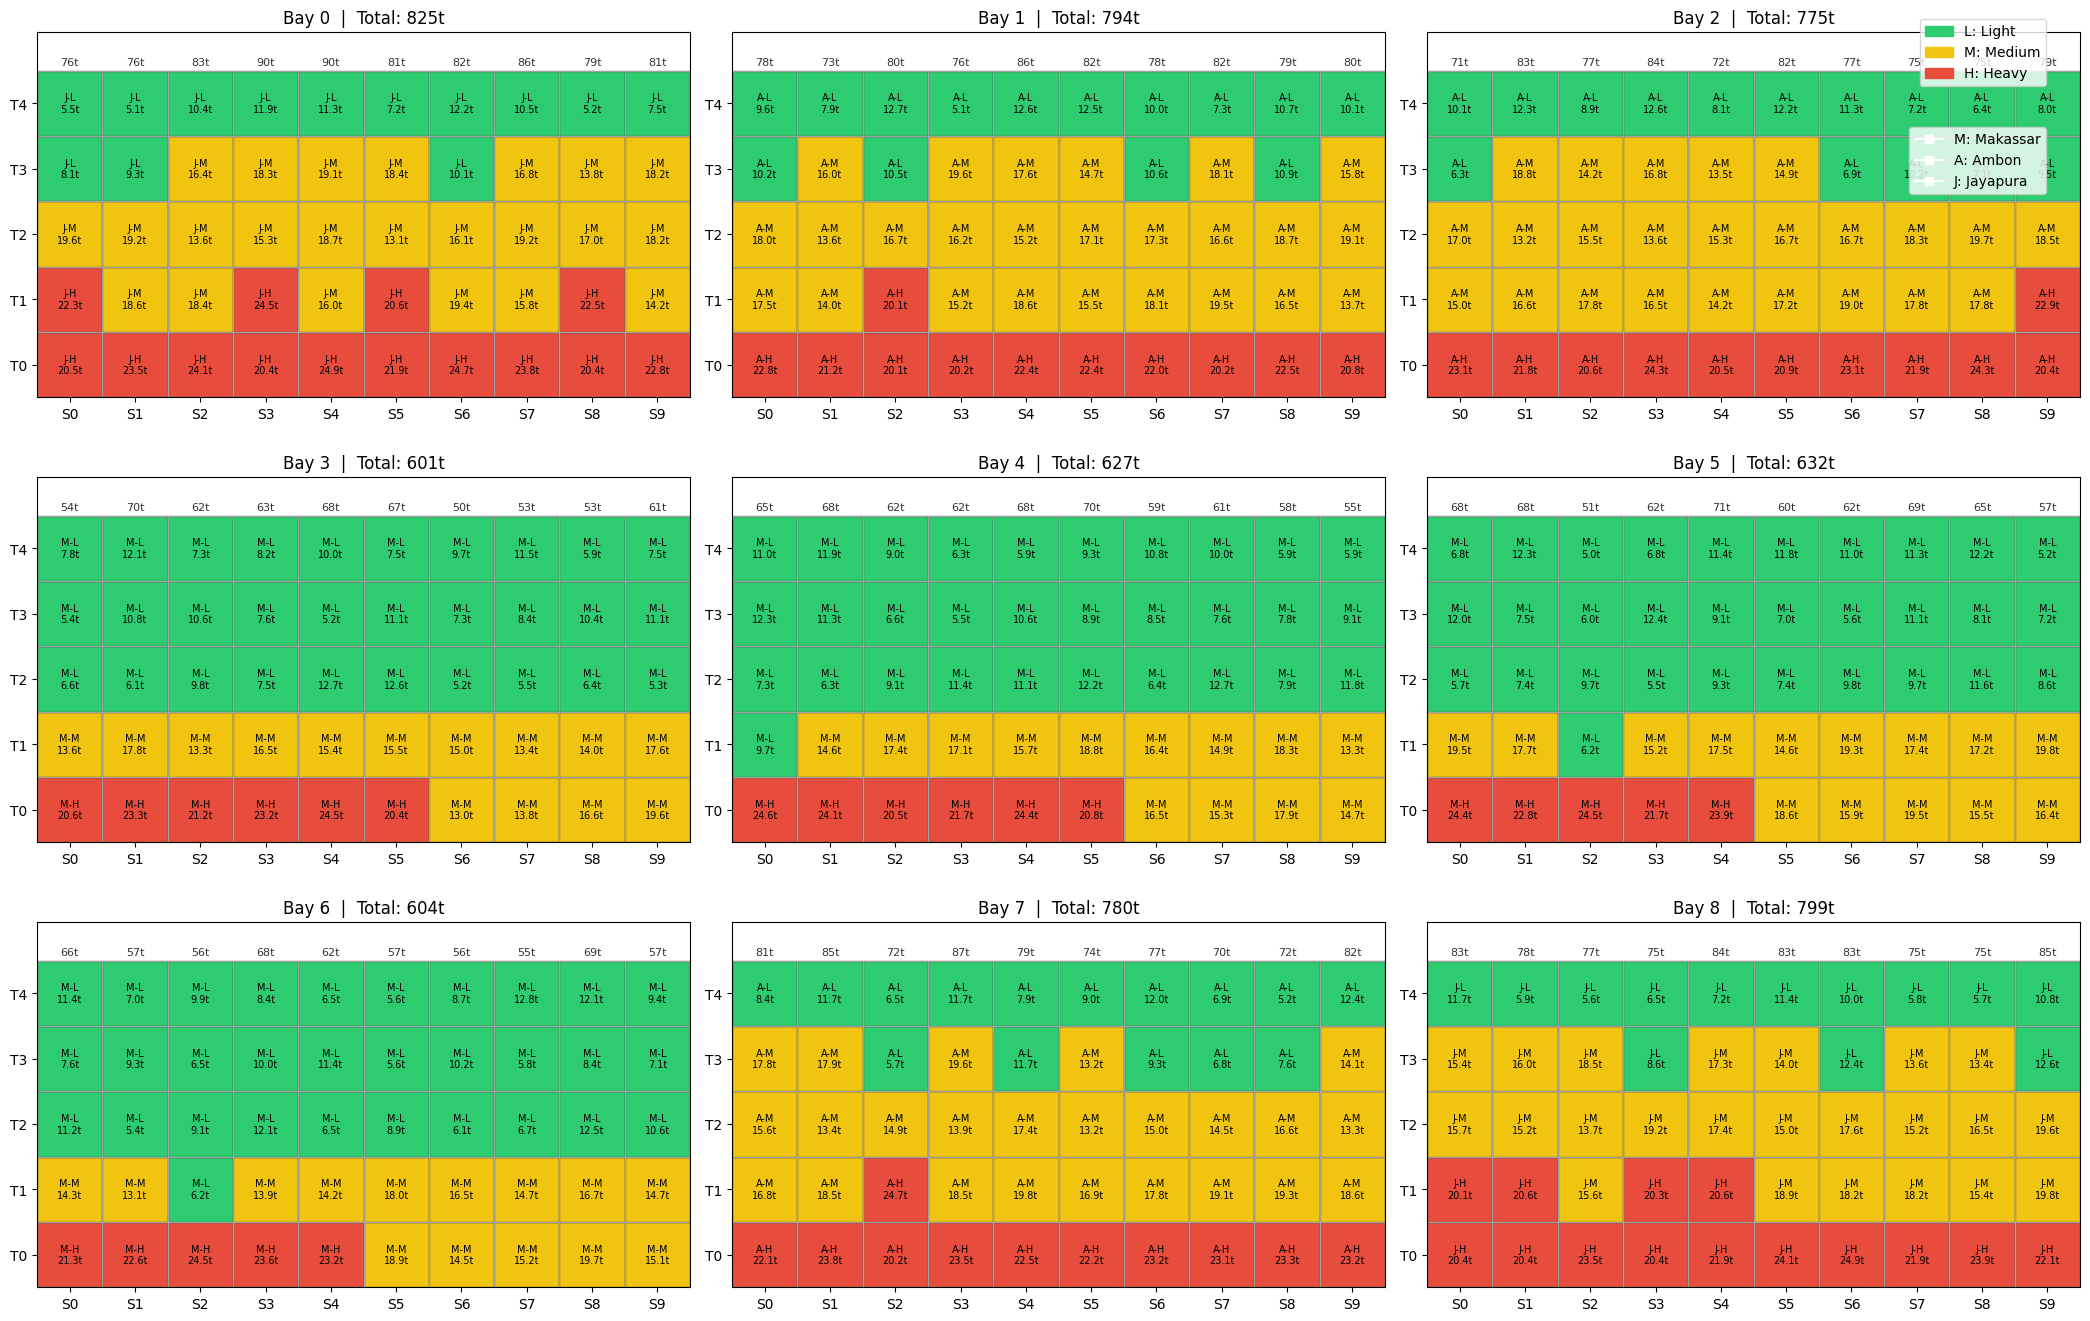

In [59]:
# Eksekusi ulang perencanaan dengan pembagian bay per tujuan
containers = generate_containers(TOTAL_CONTAINERS, ALLOCATION_PER_PORT, WEIGHT_MIX)
assignment = plan_stowage(containers, BAYS, STACKS_PER_BAY, TIERS_PER_STACK, PORTS, PORT_TO_BAYS)

# Jalankan visualisasi detail dengan berat numerik dan total bobot
visualize_all_bays_detailed(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)



In [60]:
from collections import defaultdict

def compute_weight_tensors(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                           stacks_per_bay: int, tiers_per_stack: int):
    # tensor bobot [bay, stack, tier]
    W = np.zeros((bays, stacks_per_bay, tiers_per_stack), dtype=float)
    for (bay, stack, tier), c in assignment.items():
        W[bay, stack, tier] = c.weight_ton
    return W


def evaluate_balance(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, float]:
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total = W.sum()

    # Kiri-Kanan (transversal): bagi di tengah stacks
    left = W[:, :stacks_per_bay//2, :].sum()
    right = W[:, stacks_per_bay//2:, :].sum()
    lr_diff = abs(left - right)
    lr_ratio = lr_diff / total if total > 0 else 0.0

    # Depan-Belakang (longitudinal): bagi di tengah bays
    front = W[:bays//2, :, :].sum()   # asumsi bay kecil = depan
    aft = W[bays//2:, :, :].sum()     # bay besar = belakang
    fa_diff = abs(front - aft)
    fa_ratio = fa_diff / total if total > 0 else 0.0

    # Atas–Bawah (vertical): bawah = tier rendah
    bottom = W[:, :, :tiers_per_stack//2].sum()
    top = W[:, :, tiers_per_stack//2:].sum()
    vt_diff = abs(bottom - top)
    vt_ratio = vt_diff / total if total > 0 else 0.0

    # Kuadran (depan/kiri, depan/kanan, belakang/kiri, belakang/kanan)
    mid_bay = bays//2
    mid_stack = stacks_per_bay//2
    q_fl = W[:mid_bay, :mid_stack, :].sum()
    q_fr = W[:mid_bay, mid_stack:, :].sum()
    q_al = W[mid_bay:, :mid_stack, :].sum()
    q_ar = W[mid_bay:, mid_stack:, :].sum()
    quad_std = np.std([q_fl, q_fr, q_al, q_ar])

    # Pusat massa (CoG) sederhana dalam koordinat kontinu (bay, stack, tier)
    bays_idx, stacks_idx, tiers_idx = np.indices(W.shape)
    cog_bay = float((W * bays_idx).sum() / total) if total > 0 else 0.0
    cog_stack = float((W * stacks_idx).sum() / total) if total > 0 else 0.0
    cog_tier = float((W * tiers_idx).sum() / total) if total > 0 else 0.0

    return {
        "total_weight_t": float(total),
        "left_t": float(left), "right_t": float(right), "lr_diff_t": float(lr_diff), "lr_imbalance_ratio": float(lr_ratio),
        "front_t": float(front), "aft_t": float(aft), "fa_diff_t": float(fa_diff), "fa_imbalance_ratio": float(fa_ratio),
        "bottom_t": float(bottom), "top_t": float(top), "vt_diff_t": float(vt_diff), "vt_imbalance_ratio": float(vt_ratio),
        "q_front_left_t": float(q_fl), "q_front_right_t": float(q_fr), "q_aft_left_t": float(q_al), "q_aft_right_t": float(q_ar),
        "quadrant_std_t": float(quad_std),
        "cog_bay": cog_bay, "cog_stack": cog_stack, "cog_tier": cog_tier,
    }


def print_balance_report(metrics: Dict[str, float], bays: int, stacks_per_bay: int, tiers_per_stack: int):
    print(f"Total berat: {metrics['total_weight_t']:.1f} t")
    print("Kiri–Kanan (LR):")
    print(f"  Left: {metrics['left_t']:.1f} t | Right: {metrics['right_t']:.1f} t | Selisih: {metrics['lr_diff_t']:.1f} t ({metrics['lr_imbalance_ratio']*100:.2f}%)")
    print("Depan–Belakang (FA):")
    print(f"  Front: {metrics['front_t']:.1f} t | Aft: {metrics['aft_t']:.1f} t | Selisih: {metrics['fa_diff_t']:.1f} t ({metrics['fa_imbalance_ratio']*100:.2f}%)")
    print("Atas–Bawah (Vertical):")
    print(f"  Bottom: {metrics['bottom_t']:.1f} t | Top: {metrics['top_t']:.1f} t | Selisih: {metrics['vt_diff_t']:.1f} t ({metrics['vt_imbalance_ratio']*100:.2f}%)")
    print("Kuadran (Front/Aft x Left/Right):")
    print(f"  FL: {metrics['q_front_left_t']:.1f} t | FR: {metrics['q_front_right_t']:.1f} t | AL: {metrics['q_aft_left_t']:.1f} t | AR: {metrics['q_aft_right_t']:.1f} t | Std: {metrics['quadrant_std_t']:.1f} t")
    print("Pusat Massa (indeks kontinu):")
    print(f"  Bay: {metrics['cog_bay']:.2f} dari [0..{bays-1}], Stack: {metrics['cog_stack']:.2f} dari [0..{stacks_per_bay-1}], Tier: {metrics['cog_tier']:.2f} dari [0..{tiers_per_stack-1}]")



In [61]:
# Jalankan evaluasi keseimbangan
metrics = evaluate_balance(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
print_balance_report(metrics, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)



Total berat: 6437.9 t
Kiri–Kanan (LR):
  Left: 3269.2 t | Right: 3168.7 t | Selisih: 100.5 t (1.56%)
Depan–Belakang (FA):
  Front: 2995.8 t | Aft: 3442.1 t | Selisih: 446.3 t (6.93%)
Atas–Bawah (Vertical):
  Bottom: 3439.7 t | Top: 2998.2 t | Selisih: 441.4 t (6.86%)
Kuadran (Front/Aft x Left/Right):
  FL: 1512.0 t | FR: 1483.8 t | AL: 1757.2 t | AR: 1684.9 t | Std: 114.9 t
Pusat Massa (indeks kontinu):
  Bay: 3.93 dari [0..8], Stack: 4.47 dari [0..9], Tier: 1.58 dari [0..4]


In [62]:
# Parameter hidrostatik sederhana untuk perhitungan GM
# CATATAN: Angka-angka ini placeholder dan harus diganti dengan data kapal sebenarnya.
# Satuan ton, meter.
LIGHTSHIP_DISP_T = 3000.0   # berat lightship (tanpa muatan)
LIGHTSHIP_KG_M = 6.5        # vertical CoG lightship di atas keel
LIGHTSHIP_LCG_M = 0.0       # longitudinal CoG lightship relatif titik nol bay tengah
LIGHTSHIP_TCG_M = 0.0       # transverse CoG lightship relatif centerline

KB_M = 3.0                  # jarak dari keel ke pusat daya apung (KB)
BM_TRANSVERSE_M = 7.0       # BMt (metacentric radius transversal)
BM_LONGITUDINAL_M = 50.0    # BMl (metacentric radius longitudinal)

# Geometri vertikal tier untuk menghitung KG muatan
TIER_HEIGHT_M = 2.6         # jarak antar tier (dek bawah ke atas)
TIER_BASE_Z_M = 1.3         # elevasi tier 0 dari keel (misal center of mass container)



In [63]:
def compute_cargo_cog(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                       stacks_per_bay: int, tiers_per_stack: int) -> Tuple[float,float,float,float]:
    """Hitung total berat kargo dan CoG 3D (LCG, TCG, KG) dalam meter.
    - Asumsi jarak antar stack seragam, kita nol-kan di tengah (TCG=0 di centerline).
    - Asumsi jarak antar bay seragam, nol di tengah (LCG=0 di tengah kapal).
    - KG dihitung dari elevasi tier (TIER_BASE_Z_M + tier*TIER_HEIGHT_M).
    """
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total_w = W.sum()
    if total_w == 0:
        return 0.0, 0.0, 0.0, 0.0

    # koordinat kontinu dengan nol di tengah
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_coords = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)
    tier_z = np.array([TIER_BASE_Z_M + i*TIER_HEIGHT_M for i in range(tiers_per_stack)])

    # index grid
    b_idx, s_idx, t_idx = np.indices(W.shape)

    # map ke koordinat
    L = bay_coords[b_idx]
    T = stack_coords[s_idx]
    Z = tier_z[t_idx]

    LCG = float((W * L).sum() / total_w)
    TCG = float((W * T).sum() / total_w)
    KG = float((W * Z).sum() / total_w)
    return float(total_w), LCG, TCG, KG


def compute_GM(total_cargo_t: float, cargo_LCG: float, cargo_TCG: float, cargo_KG: float):
    """Gabungkan lightship + cargo untuk KG total dan hitung GMt/GMl.
    Mengembalikan: displacement total, KG_total, GMt, GMl.
    """
    disp_total = LIGHTSHIP_DISP_T + total_cargo_t
    KG_total = (LIGHTSHIP_DISP_T*LIGHTSHIP_KG_M + total_cargo_t*cargo_KG) / disp_total if disp_total > 0 else 0.0
    GMt = KB_M + BM_TRANSVERSE_M - KG_total
    GMl = KB_M + BM_LONGITUDINAL_M - KG_total
    return disp_total, KG_total, GMt, GMl


def print_GM_report(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int):
    total_cargo_t, LCG, TCG, KG = compute_cargo_cog(assignment, bays, stacks_per_bay, tiers_per_stack)
    disp_total, KG_total, GMt, GMl = compute_GM(total_cargo_t, LCG, TCG, KG)
    print("=== Perhitungan GM (sederhana) ===")
    print(f"Cargo: {total_cargo_t:.1f} t | LCG: {LCG:.2f} | TCG: {TCG:.2f} | KG: {KG:.2f} m")
    print(f"Lightship: {LIGHTSHIP_DISP_T:.1f} t | KG: {LIGHTSHIP_KG_M:.2f} m")
    print(f"KB: {KB_M:.2f} m | BMt: {BM_TRANSVERSE_M:.2f} m | BMl: {BM_LONGITUDINAL_M:.2f} m")
    print(f"Displacement total: {disp_total:.1f} t | KG_total: {KG_total:.2f} m")
    print(f"GMt (transversal): {GMt:.2f} m")
    print(f"GMl (longitudinal): {GMl:.2f} m")
    # Rule-of-thumb threshold (sangat kasar, tergantung kapal): GMt > 0.5 m dianggap aman, GMl biasanya besar
    status = "AMAN" if GMt > 0.5 else "RENTAN"
    print(f"Status transversal: {status}")



In [64]:
# Jalankan perhitungan GM sederhana
print_GM_report(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)



=== Perhitungan GM (sederhana) ===
Cargo: 6437.9 t | LCG: -0.07 | TCG: -0.03 | KG: 5.41 m
Lightship: 3000.0 t | KG: 6.50 m
KB: 3.00 m | BMt: 7.00 m | BMl: 50.00 m
Displacement total: 9437.9 t | KG_total: 5.76 m
GMt (transversal): 4.24 m
GMl (longitudinal): 47.24 m
Status transversal: AMAN
